In [37]:
#commented uncessary print statements
#merged blocks of code inorder to run loops and generate statistics

In [3]:
#importing the required libraries

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import cProfile
from numba import jit

In [39]:
#opening a file to store data
f = open("phi_star_data.txt","w+") 

In [40]:
#user controlled variables

# with open("phi_star_data.txt","w+")  as f :
for p_rew in range (0,11) :
    p_rew = p_rew*0.1
    print (p_rew)
    
    # p_rew = 1 #probability of rewiring in the watts-strogatz network
    nn = 2 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd

    start = 1 #initial condition : fraction of infected individuals

    p = 1  #probability of dose transfer upon interaction
    rho = 1   #probability of becoming susceptible after recovery
    r = 1    #probability of recovery when dose level drops below threshold

    N = 100   #number of individuals
    T = 1000  #number of time steps

    mem_time_steps = 12 #the number of previous time steps which the individual remembers about 

    d_star = 3*np.ones((N,1),dtype=np.int32)
    # print('d_star')
    # print(d_star)
    # print(type(d_star))
    # print(d_star.shape)

    #initialising variables and arrays to store information

    kount = 0

#     phi_star = 999*np.ones([11,2]) #fraction of steady state infected
    # print('phi_star')
    # print(phi_star)
    # print(phi_star.shape)

    phi = 999*np.ones([1,T]) #fraction of steady state infected
    # print('phi')
    # print(phi)
    # print(phi.shape)

    t = np.arange(0,T) #time steps
    t = np.asarray(t).reshape(1,T)
    # print('t')
    # print(t)
    # print(t.shape)
    # print(type(t))

    partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
    partner = np.asarray(partner)
    # print('partner')
    # print(partner.shape)
    # print(type(partner))
    indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
    indi_state[:,0] = 1
    # print('indi_state')
    # print(indi_state)
    # print(type(indi_state))

    d_ini = np.zeros((N,mem_time_steps))
    # print('d_ini')
    # print(type(d_ini))
    # print(d_ini.shape)
    # print(d_ini)
    d = 999*np.ones((N,T)) #doses
    # print('d')
    # print(d)
    # print(type(d))
    D = 999*np.ones((N,T)) #cumulative doses
    # print('D')
    # print(D)
    # print(type(D))

    z1 = 2*np.ones((N,T)) #stores the random numbers for deciding the dose transfer
    z2 = 2*np.ones((N,T)) #stores the random numbers for deciding resusceptibility upon recovery
    z3 = 2*np.ones((N,T)) #stores the random numbers for deciding immunity upon recovery
    # print('z1')
    # print(z1)
    # print(type(z1))

    #initial state of individuals
    #randomly grouping into i, s or r

    infec = random.sample(range(0, N), np.int32(start*N)) #radnomly infecting few individuals as initial condition
    # np.random.shuffle(infec)
    infec = np.asarray(infec).reshape(np.int32(start*N),1)
    if start != 0 :
        indi_state[infec[:,0],0] = 2
    # print('infec')
    # print(type(infec))
    # print(infec)
    # print('indi_state')
    # print(indi_state)

    phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N
    # print('phi')
    # print(phi)

    #implementing marc's initial condition
    I = np.where(indi_state[:,0]==2)
    I = np.transpose(np.asarray(I))
    # print('I')
    # print(type(I))
    # print(I.shape)
    # print(I)

    if len(I) != 0 :
        for i in range(0,len(I)) : 
            d_ini[I[i],0:] = p
    else :
        d_ini[:,0:] = 0

    # print('d_ini')
    # print(d_ini)

    #creating the static Watts-Strogatz network

    G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)

    node_array = np.asarray(node_list).reshape(N,1)
    # print('node_array')
    # print(node_array)
    # print(node_array.shape)
    # print(type(node_array))

    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G)
    # print('adjacency matrix')
    # print(adj_mat.shape)
    # print(type(adj_mat))
    # print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

    kount = 0
    # val = np.int32(N/2)
    for k in range(1,T): #loop for time
    #     print('k = ',k)

        for n in range(0,N): #loop for nodes
    #         print('n = ',n)
            partner[n,k] = np.random.randint(0,N)
    #         print(partner[n,k])
            z1[n,k] = np.random.uniform()

            #if one is infected and the other is susceptible and they are connected 
            if (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
                if p >= z1[n,k] :
    #                 print('postive dose to the one')
                    d[n,k] = 1 #the one receives constant dose
                    d[partner[n,k],k] = 0 #the other receives no dose
                else :
    #                 'interaction but no dose'
                    d[n,k] = 0
                    d[partner[n,k],k] = 0
            #if both are infected and they are connected
            elif (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
                if p >= z1[n,k] :
    #                 'postive dose for both'
                    d[n,k] = 1 #the other receives constant dose
                    d[partner[n,k],k] = 0 #the one STILL receives NO DOSE
                else :
    #                 'interaction but no dose'
                    d[n,k] = 0
                    d[partner[n,k],k] = 0
            else :
    #             'no interaction at all'
                    d[n,k] = 0
                    d[partner[n,k],k] = 0


    #     updating cumulative dose
        D[:,k] = 0
        m = k - (mem_time_steps)
        if m > 0 :
            D[:,k] = np.sum(d[:,m:k+1:1],1)
        if m <= 0 :
            while m <= 0 :
                m = m + 1
        D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,1:((mem_time_steps-(k-m)))+1:1],1)

        for n in range(0,N):
    #         print(n)
    #         print(k)
    #         if threshold is met and is susceptible
            if (D[n,k] >= d_star[n,0]) and (indi_state[n,k-1] == 1) :
    #             'above thresh becomes infected'
                indi_state[n,k] = 2 #susceptible becomes infected
            elif (D[n,k] < d_star[n,0]) and (indi_state[n,k-1] == 2) :
    #         recovery : if drops bel threshold and is infected
                z2[n,k] = np.random.uniform()
                if r >= z2[n,k] :
    #                 'below thresh'
                    z3[n,k] = np.random.uniform()
                    if rho >= z3[n,k] :
    #                     'below thresh becomes susceptible'
                        indi_state[n,k] = 1
                    else :
    #                     'below thresh becomes immune'
                        indi_state[n,k] = 3
                else :
    #                 'below thresh stays infected'
                    indi_state[n,k] = 2
            else :
    #             'retains previous state'
                indi_state[n,k] = indi_state[n,k-1]

        phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
    #     kount = kount + 1

    phi_star = sum(phi[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
    print(phi_star)

    f.write("%f\t%f\n" % (p_rew,phi_star))
    f.flush()

0.0
0.0
0.1
0.0
0.2
0.0
0.30000000000000004
0.0
0.4
0.0
0.5
0.0
0.6000000000000001
0.0
0.7000000000000001
0.0
0.8
0.0
0.9
0.0
1.0
0.0


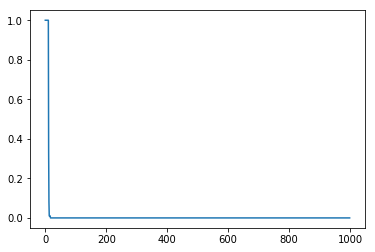

In [41]:
#printing out the necessary variables
# print(d)
# print(D)
# print(z1)
# print(phi)

plt.plot(t[0,:],phi[0,:])
plt.show()

In [2]:
%timeit np.random.random(100)

2.37 µs ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [4]:
def simpleLoop(N=1000):
    for i in range(N):
        
        p=np.random.random()
        a=np.power(p,3)
        
    return

@jit(nopython=True)
def numbaLoop(N=1000):
    
    for i in range(N):
        
        p=np.random.random()
        a=np.power(p,3)
        
    return

In [5]:
timeit simpleLoop()

3.54 ms ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit numbaLoop()

15.4 µs ± 91.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
3*10**(-3)/(15*10**(-6))

200.00000000000003